# InSituPy demonstration

In [1]:
## The following code ensures that all functions and init files are reloaded before executions.
%load_ext autoreload
%autoreload 2

In [29]:
from insitupy import XeniumData
from pathlib import Path
import scanpy as sc
import requests
from insitupy.io import download_url
import shutil
import os

## Download example data

To demonstrate the functionalities of InSituPy, we use publicly available data provided by 10x Genomics. The dataset for this tutorial can be found here: 

https://www.10xgenomics.com/products/xenium-in-situ/preview-dataset-human-breast

Download following three parts of the dataset:
1. Xenium output files: 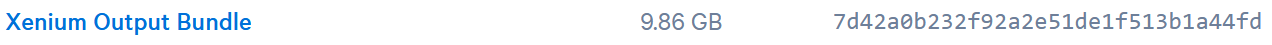
2. Unregistered H&E image: 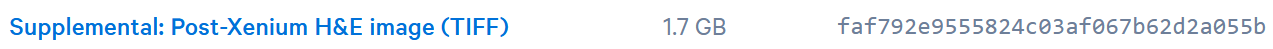
3. Unregistered IF image: 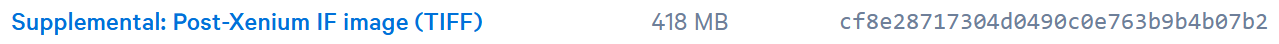

### Move files into correct input data structure
1. Unzip the Xenium output files and move the files into a folder called `output-XETG00000__slide_id__sample_id`.
2. Move unregistered images into a folder named `unregistered_images`.
3. The final structure should look like this:

    ```
    demo_dataset
    ├───output-XETG00000__slide_id__sample_id
    │   ├───analysis
    │   │   ├───clustering
    │   │   ├───diffexp
    │   │   ├───pca
    │   │   ├───tsne
    │   │   └───umap
    │   └───cell_feature_matrix
    └───unregistered_images
    ```


In [21]:
# output directory
out_dir = Path("out")

# URLs for the data
xeniumdata_url = "https://cf.10xgenomics.com/samples/xenium/1.0.1/Xenium_FFPE_Human_Breast_Cancer_Rep1/Xenium_FFPE_Human_Breast_Cancer_Rep1_outs.zip"
he_url = "https://cf.10xgenomics.com/samples/xenium/1.0.1/Xenium_FFPE_Human_Breast_Cancer_Rep1/Xenium_FFPE_Human_Breast_Cancer_Rep1_he_image.tif"
if_url = "https://cf.10xgenomics.com/samples/xenium/1.0.1/Xenium_FFPE_Human_Breast_Cancer_Rep1/Xenium_FFPE_Human_Breast_Cancer_Rep1_if_image.tif"

#### Download and rename images

The images can be either stored as `.tif` or `.ome.tif` and need to be name using following structure: `"{slide_id}__{region_id}__{image_names}__{image_type}"`, with:
- `slide_id`: ID found on the Xenium slide.
- `region_id`: ID for the sample on the Xenium slide.
- `image_names`: Name of the image. In case of multi-channel `"IF"` images, this is expeted to be a `"_"`-separated list of names (e.g. `"CD20_HER2_DAPI"`). For `"histo"` RGB images it is only one name (e.g. `"HE"`)
- `image_type`: Type of image. Can be either `"histo"` for RGB images or `"IF"` for (multi-channel) grayscale images.
    

In [55]:
# download the image data and save into a folder called "unregistered_images"
image_dir = out_dir / "unregistered_images"
download_url(if_url, out_dir=image_dir, file_name="slide_id__sample_id__CD20_HER2_DAPI__IF")
download_url(he_url, out_dir=image_dir, file_name="slide_id__sample_id__HE__histo")

out\unregistered_images\slide_id__sample_id__CD20_HER2_DAPI__IF.tif: 100%|██████████| 398M/398M [00:35<00:00, 11.6MiB/s] 
out\unregistered_images\slide_id__sample_id__HE__histo.tif: 100%|██████████| 1.58G/1.58G [02:27<00:00, 11.5MiB/s]


#### Download Xenium data

In [ ]:

# download the xenium dta and save into a folder containing information about slide id and sample id
download_url(xeniumdata_url, out_dir=out_dir)

In [31]:
# unzip the data archive
zip_file = list(out_dir.glob("*.zip"))[0]
data_dir = out_dir / "output-XETG00000__slide_id__sample_id"
shutil.unpack_archive(zip_file, data_dir)

# move output files to right position
for f in data_dir.glob("outs/*"):
    shutil.move(f, data_dir)
    
# remove empty outs folder
os.rmdir(data_dir / "outs")

## Load Xenium data into `XeniumData` object

In [62]:
xd = XeniumData(data_dir)

In [63]:
xd

XeniumData
Slide ID:	slide_id
Sample ID:	sample_id
Data path:	out
Data folder:	output-XETG00000__slide_id__sample_id
Metadata file:	experiment.xenium

In [64]:
image_dir

WindowsPath('out/unregistered_images')

In [67]:
xd.register_images(img_dir=image_dir, img_suffix=".tif")

Processing sample sample_id of slide slide_id
	Only unmodified metadata file (`experiment.xenium`) found. Information will be added to new file (`experiment_modified.xenium`).
	Processing following IF images: CD20, HER2, DAPI
		Loading images...
		Select image with nuclei from IF image (channel: 2)
		Load image into memory...
		Rescale image and template to save memory.
			Rescaled to following dimensions: (3314, 4827)
			Rescaled to following dimensions: (3412, 4688)
		Convert scaled images to 8 bit
		Extract common features from image and template
		2023-11-07 12:55:53: Get features...
			Method: SIFT...
		2023-11-07 12:55:58: Compute matches...
		2023-11-07 12:56:03: Filter matches...
			Sufficient number of good matches found (12491).
		2023-11-07 12:56:03: Display matches...
		2023-11-07 12:56:05: Fetch keypoints...
		2023-11-07 12:56:05: Estimate 2D affine transformation matrix...
		2023-11-07 12:56:05: Register image by affine transformation...
		Save OME-TIFF to out\registered_

In [68]:
xd

XeniumData
Slide ID:	slide_id
Sample ID:	sample_id
Data path:	out
Data folder:	output-XETG00000__slide_id__sample_id
Metadata file:	experiment.xenium
    ➤ images
       nuclei:	(25778, 35416)

In [69]:
xd.read_images()

In [80]:
xd.show()

Viewer(camera=Camera(center=(0.0, 2738.80625, 3762.84375), zoom=0.0935369856096945, angles=(0.0, 0.0, 90.0), perspective=0.0, mouse_pan=True, mouse_zoom=True), cursor=Cursor(position=(1.0, 1.0), scaled=True, size=1, style=<CursorStyle.STANDARD: 'standard'>), dims=Dims(ndim=2, ndisplay=2, last_used=0, range=((0.0, 5477.825, 0.2125), (0.0, 7525.9, 0.2125)), current_step=(12888, 17707), order=(0, 1), axis_labels=('0', '1')), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False), layers=[<Image layer 'nuclei' at 0x297ba779580>, <Image layer 'CD20' at 0x297b98cffd0>, <Image layer 'HER2' at 0x297c2ee10d0>, <Image layer 'HE' at 0x297cf628280>], help='use <2> for transform', status='Ready', tooltip=Tooltip(visible=False, text=''), theme='dark', title='napari', mouse_over_canvas=False, mouse_move_callbacks=[], mouse_drag_callbacks=[], mouse_double_click_callbacks=[], mouse_wheel_callbacks=[<function dims_scroll at 0x00000297A50CF040>], _persisted_mouse_event={}, _mouse_drag_gen={}, _mouse_wh

## Load data

In [99]:
# input directories
data_dirs = [
    Path("C:/Users/ge37voy/data/2301_CRC/2301-01_20230504/01_xenium_data/output-XETG00050__0003621__Region_1__20230504__121954"),
    Path("C:/Users/ge37voy/data/datasets/Xenium_FFPE_Human_Breast_Cancer_Rep1_outs/output-XETG00000__slide_id__sample_id/"),
    Path("C:/Users/ge37voy/data/20230811__134602__2314_OTCs_Wollenberg/output-XETG00050__0003555__OTC0304-1__20230811__134819"),
    Path(r"C:\Users\ge37voy\data\20231031__144605__2303-01_Korn_Brain\output-XETG00050__0004111__CNS4__20231031__144734")
]

In [100]:
img_dirs = [elem.parent / "unregistered_images" for elem in data_dirs]

In [102]:
i = 3
data_dir = data_dirs[i]
img_dir = img_dirs[i]

In [103]:
data_dir

WindowsPath('C:/Users/ge37voy/data/20231031__144605__2303-01_Korn_Brain/output-XETG00050__0004111__CNS4__20231031__144734')

In [104]:
xd = XeniumData(data_dir)

In [105]:
xd

XeniumData
Slide ID:	0004111
Region ID:	CNS4
Data path:	C:\Users\ge37voy\data\20231031__144605__2303-01_Korn_Brain
Data folder:	output-XETG00050__0004111__CNS4__20231031__144734
Metadata file:	experiment.xenium

## Read different data modalities

In [106]:
xd.read_all()

No folder named `annotations` found. Function `read_annotations()` was skipped.
Running read_boundaries()
Running read_images()
Running read_matrix()
Running read_transcripts()


### Show overview of data

In [107]:
xd

XeniumData
Slide ID:	0004111
Region ID:	CNS4
Data path:	C:\Users\ge37voy\data\20231031__144605__2303-01_Korn_Brain
Data folder:	output-XETG00050__0004111__CNS4__20231031__144734
Metadata file:	experiment.xenium
    ➤ images
       nuclei:	(30743, 42636)
    ➤ matrix
       AnnData object with n_obs × n_vars = 125098 × 347
	       obs: 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area'
	       var: 'gene_ids', 'feature_types', 'genome'
	       obsm: 'spatial'
    ➤ transcripts
	   DataFrame with shape 32771468 x 10
    ➤ boundaries
       cells
       nuclei

## View data interactively

In [108]:
xd.show()

Viewer(camera=Camera(center=(0.0, 3266.3375, 4529.96875), zoom=0.14671715480584455, angles=(0.0, 0.0, 90.0), perspective=0.0, mouse_pan=True, mouse_zoom=True), cursor=Cursor(position=(1.0, 1.0), scaled=True, size=1, style=<CursorStyle.STANDARD: 'standard'>), dims=Dims(ndim=2, ndisplay=2, last_used=0, range=((0.0, 6532.8875, 0.2125), (0.0, 9060.15, 0.2125)), current_step=(15371, 21317), order=(0, 1), axis_labels=('0', '1')), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False), layers=[<Image layer 'nuclei' at 0x22aa29d7d30>], help='use <2> for transform', status='Ready', tooltip=Tooltip(visible=False, text=''), theme='dark', title='napari', mouse_over_canvas=False, mouse_move_callbacks=[], mouse_drag_callbacks=[], mouse_double_click_callbacks=[], mouse_wheel_callbacks=[<function dims_scroll at 0x00000229983549D0>], _persisted_mouse_event={}, _mouse_drag_gen={}, _mouse_wheel_gen={}, keymap={})

In [110]:
xd.matrix.to_df()

,2010300C02Rik,Acsbg1,Acta2,Acvrl1,Adamts2,Adamtsl1,Adgrl4,Adk,Ahr,Aldh1a2,...,Unc13c,Vat1l,Vip,Vsir,Vwc2l,Wfs1,Xbp1,Zfp366,Zfp536,Zfpm2
aaaajojo-1,2.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
aaaamjnl-1,1.0,5.0,0.0,1.0,0.0,0.0,3.0,5.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0
aaaaoakh-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0
aaabaibh-1,2.0,6.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
aaachnjj-1,4.0,6.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,5.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ojeeogmh-1,3.0,4.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,1.0,0.0
ojegbkpd-1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
ojegfndd-1,0.0,4.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,1.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
ojegpnjn-1,1.0,5.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Crop data

In [22]:
xx = xd.crop(shape_layer="Shapes", inplace=False)

napari.Viewer: napari


c:\Users\ge37voy\AppData\Local\miniconda3\envs\xparse\lib\site-packages\anndata\_core\anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


In [23]:
xx.show()

Viewer(camera=Camera(center=(0.0, 342.65625, 604.3499999999999), zoom=0.5823002078314188, angles=(0.0, 0.0, 90.0), perspective=0.0, mouse_pan=True, mouse_zoom=True), cursor=Cursor(position=(1.0, 1.0), scaled=True, size=1, style=<CursorStyle.STANDARD: 'standard'>), dims=Dims(ndim=2, ndisplay=2, last_used=0, range=((0.0, 685.525, 0.2125), (0.0, 1208.9125, 0.2125)), current_step=(1612, 2844), order=(0, 1), axis_labels=('0', '1')), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False), layers=[<Image layer 'nuclei' at 0x22a2b250fa0>, <Image layer 'HE' at 0x22a636d33a0>, <Image layer 'panCK' at 0x22a6695b1f0>], help='use <2> for transform', status='Ready', tooltip=Tooltip(visible=False, text=''), theme='dark', title='napari', mouse_over_canvas=False, mouse_move_callbacks=[], mouse_drag_callbacks=[], mouse_double_click_callbacks=[], mouse_wheel_callbacks=[<function dims_scroll at 0x00000229983549D0>], _persisted_mouse_event={}, _mouse_drag_gen={}, _mouse_wheel_gen={}, keymap={})

## Perform preprocessing steps

In [24]:
xx.normalize(transformation_method="sqrt")
#xx.hvg()
xx.reduce_dimensions(umap=True, tsne=False)

Store raw counts in anndata.layers['counts']...
Normalization, log-transformation...
Dimensionality reduction...
Leiden clustering...


In [31]:
xx.show()

Viewer(camera=Camera(center=(0.0, 342.65625, 604.3499999999999), zoom=0.5500811679918935, angles=(0.0, 0.0, 90.0), perspective=0.0, mouse_pan=True, mouse_zoom=True), cursor=Cursor(position=(1.0, 1.0), scaled=True, size=1, style=<CursorStyle.STANDARD: 'standard'>), dims=Dims(ndim=2, ndisplay=2, last_used=0, range=((0.0, 685.525, 0.2125), (0.0, 1208.9125, 0.2125)), current_step=(1612, 2844), order=(0, 1), axis_labels=('0', '1')), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False), layers=[<Image layer 'nuclei' at 0x22a89fd2340>, <Image layer 'HE' at 0x22a8a0b51c0>, <Image layer 'panCK' at 0x22a9227a190>], help='use <2> for transform', status='Ready', tooltip=Tooltip(visible=False, text=''), theme='dark', title='napari', mouse_over_canvas=False, mouse_move_callbacks=[], mouse_drag_callbacks=[], mouse_double_click_callbacks=[], mouse_wheel_callbacks=[<function dims_scroll at 0x00000229983549D0>], _persisted_mouse_event={}, _mouse_drag_gen={}, _mouse_wheel_gen={}, keymap={})

In [28]:
xx.matrix.obs

,transcript_counts,control_probe_counts,control_codeword_counts,unassigned_codeword_counts,total_counts,cell_area,nucleus_area,leiden
aalncfpb-1,92,0,0,0,92,106.342969,13.682344,6
aalndmje-1,125,0,0,0,125,100.969375,37.073281,6
aalnkbfm-1,208,0,0,0,208,225.961875,111.581094,6
aalobdob-1,69,0,0,0,69,38.924688,19.868750,4
aalocmdk-1,33,0,0,0,33,29.757969,10.476250,4
...,...,...,...,...,...,...,...,...
lagebbcc-1,124,0,0,0,124,107.968594,23.345781,5
lagegmnl-1,25,0,0,0,25,17.610938,9.302188,1
lagejmkl-1,48,0,0,0,48,35.808906,24.790781,1
lagepcdm-1,146,0,0,0,146,115.374219,28.493594,1


c:\Users\ge37voy\AppData\Local\miniconda3\envs\xparse\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
c:\Users\ge37voy\AppData\Local\miniconda3\envs\xparse\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
c:\Users\ge37voy\AppData\Local\miniconda3\envs\xparse\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


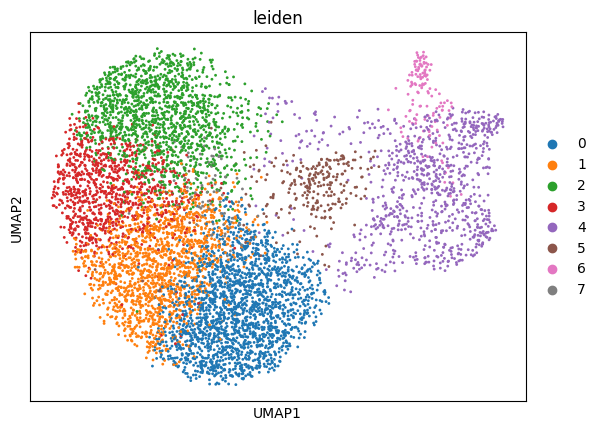

In [26]:
sc.pl.umap(xx.matrix, color="leiden")

In [71]:
xx.show()

Viewer(camera=Camera(center=(0.0, 344.0375, 481.20625), zoom=1.2128338525422735, angles=(0.0, 0.0, 90.0), perspective=0.0, mouse_pan=True, mouse_zoom=True), cursor=Cursor(position=(1.0, 1.0), scaled=True, size=1, style=<CursorStyle.STANDARD: 'standard'>), dims=Dims(ndim=2, ndisplay=2, last_used=0, range=((0.0, 688.2875, 0.2125), (0.0, 962.625, 0.2125)), current_step=(1619, 2264), order=(0, 1), axis_labels=('0', '1')), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False), layers=[<Image layer 'nuclei' at 0x1a612167910>, <Image layer 'HE' at 0x1a612269940>, <Image layer 'panCK' at 0x1a61e6c3520>], help='use <2> for transform', status='Ready', tooltip=Tooltip(visible=False, text=''), theme='dark', title='napari', mouse_over_canvas=False, mouse_move_callbacks=[], mouse_drag_callbacks=[], mouse_double_click_callbacks=[], mouse_wheel_callbacks=[<function dims_scroll at 0x000001A48CCD4A60>], _persisted_mouse_event={}, _mouse_drag_gen={}, _mouse_wheel_gen={}, keymap={})

In [51]:
xx.show(keys=["leiden", "ACTA2", "LYZ"])

hey


Viewer(camera=Camera(center=(0.0, 342.65625, 604.3499999999999), zoom=0.5500811679918935, angles=(0.0, 0.0, 90.0), perspective=0.0, mouse_pan=True, mouse_zoom=True), cursor=Cursor(position=(1.0, 1.0), scaled=True, size=1, style=<CursorStyle.STANDARD: 'standard'>), dims=Dims(ndim=2, ndisplay=2, last_used=0, range=((0.0, 685.6707032624009, 0.2125), (0.0, 1208.9793136334529, 0.2125)), current_step=(1612, 2844), order=(0, 1), axis_labels=('0', '1')), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False), layers=[<Image layer 'nuclei' at 0x22be1ae17c0>, <Image layer 'HE' at 0x22be1b1f5b0>, <Image layer 'panCK' at 0x22be2bba640>, <Points layer 'leiden' at 0x22bf5e3f700>, <Points layer 'ACTA2' at 0x22be4b79310>, <Points layer 'LYZ' at 0x22bf5ff9760>], help='use <5> for transform, use <2> for add points, use <3> for select points', status='Ready', tooltip=Tooltip(visible=False, text=''), theme='dark', title='napari', mouse_over_canvas=False, mouse_move_callbacks=[], mouse_drag_callbacks=[],

## Save results

In [40]:
out_dir = data_dir.parent / "cropped_processed"

In [41]:
xx.save(out_dir, overwrite=True)

## Reload data

In [61]:
dd = XeniumData(out_dir)

In [62]:
dd

XeniumData
Slide ID:	0003621
Region ID:	Region_1
Data path:	C:\Users\ge37voy\data\2301_CRC\2301-01_20230504\01_xenium_data
Data folder:	cropped_processed
Metadata file:	xeniumdata.json

In [63]:
dd.read_matrix()

In [64]:
dd.read_images()

In [72]:
dd.show()

Viewer(camera=Camera(center=(0.0, 342.65625, 604.3499999999999), zoom=0.5437945260719862, angles=(0.0, 0.0, 90.0), perspective=0.0, mouse_pan=True, mouse_zoom=True), cursor=Cursor(position=(1.0, 1.0), scaled=True, size=1, style=<CursorStyle.STANDARD: 'standard'>), dims=Dims(ndim=2, ndisplay=2, last_used=0, range=((0.0, 685.525, 0.2125), (0.0, 1208.9125, 0.2125)), current_step=(1612, 2844), order=(0, 1), axis_labels=('0', '1')), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False), layers=[<Image layer 'nuclei' at 0x22bf9e82490>, <Image layer 'HE' at 0x22bfa003b20>, <Image layer 'panCK' at 0x22c0a143b50>], help='use <2> for transform', status='Ready', tooltip=Tooltip(visible=False, text=''), theme='dark', title='napari', mouse_over_canvas=False, mouse_move_callbacks=[], mouse_drag_callbacks=[], mouse_double_click_callbacks=[], mouse_wheel_callbacks=[<function dims_scroll at 0x00000229983549D0>], _persisted_mouse_event={}, _mouse_drag_gen={}, _mouse_wheel_gen={}, keymap={})

In [69]:
dd.matrix.obs.unassigned_codeword_counts

aalncfpb-1    0
aalndmje-1    0
aalnkbfm-1    0
aalobdob-1    0
aalocmdk-1    0
             ..
lagebbcc-1    0
lagegmnl-1    0
lagejmkl-1    0
lagepcdm-1    0
lagfcing-1    0
Name: unassigned_codeword_counts, Length: 7275, dtype: int64

In [79]:
dd.matrix.obs.leiden.unique()

['6', '4', '0', '1', '7', '3', '5', '2']
Categories (8, object): ['0', '1', '2', '3', '4', '5', '6', '7']

In [73]:
v = dd.viewer

In [92]:
l = v.layers['leiden']
a = v.layers['ACTA2']

In [78]:
len(l.face_color_cycle)

18

In [96]:
a.face_color_mode

<ColorMode.COLORMAP: 'colormap'>

In [93]:
len(a.face_color_cycle)

1

In [90]:
l.face_color_m

<ColorMode.CYCLE: 'cycle'>

In [70]:
dd.show()

Viewer(camera=Camera(center=(0.0, 342.65625, 604.3499999999999), zoom=1.199176946222328, angles=(0.0, 0.0, 90.0), perspective=0.0, mouse_pan=True, mouse_zoom=True), cursor=Cursor(position=(1.0, 1.0), scaled=True, size=1, style=<CursorStyle.STANDARD: 'standard'>), dims=Dims(ndim=2, ndisplay=2, last_used=0, range=((0.0, 685.525, 0.2125), (0.0, 1208.9125, 0.2125)), current_step=(1612, 2844), order=(0, 1), axis_labels=('0', '1')), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False), layers=[<Image layer 'nuclei' at 0x22b40bd8f40>, <Image layer 'HE' at 0x22b40c47f70>, <Image layer 'panCK' at 0x22bf4cc4f70>], help='use <2> for transform', status='Ready', tooltip=Tooltip(visible=False, text=''), theme='dark', title='napari', mouse_over_canvas=False, mouse_move_callbacks=[], mouse_drag_callbacks=[], mouse_double_click_callbacks=[], mouse_wheel_callbacks=[<function dims_scroll at 0x00000229983549D0>], _persisted_mouse_event={}, _mouse_drag_gen={}, _mouse_wheel_gen={}, keymap={})

In [24]:
dd.read_transcripts()

In [56]:
dd.show()

Viewer(camera=Camera(center=(0.0, 350.94375, 639.4124999999999), zoom=0.6944675195215152, angles=(0.0, 0.0, 90.0), perspective=0.0, mouse_pan=True, mouse_zoom=True), cursor=Cursor(position=(1.0, 1.0), scaled=True, size=1, style=<CursorStyle.STANDARD: 'standard'>), dims=Dims(ndim=2, ndisplay=2, last_used=0, range=((0.0, 702.1, 0.2125), (0.0, 1279.0375, 0.2125)), current_step=(1651, 3009), order=(0, 1), axis_labels=('0', '1')), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False), layers=[<Image layer 'nuclei' at 0x250910a10d0>, <Image layer 'HE' at 0x2508250a040>, <Image layer 'panCK' at 0x250826fdc70>], help='use <2> for transform', status='Ready', tooltip=Tooltip(visible=False, text=''), theme='dark', title='napari', mouse_over_canvas=False, mouse_move_callbacks=[], mouse_drag_callbacks=[], mouse_double_click_callbacks=[], mouse_wheel_callbacks=[<function dims_scroll at 0x00000250014D9A60>], _persisted_mouse_event={}, _mouse_drag_gen={}, _mouse_wheel_gen={}, keymap={})

In [48]:
list(dd.xd_metadata["images"].values())

['images/morphology_focus.ome.tif',
 'images/0003621__Region_1__HE__registered.ome.tif',
 'images/0003621__Region_1__panCK__registered.ome.tif']

In [21]:
xx

XeniumData
Slide ID:	0003621
Region ID:	Region_1
Data path:	C:\Users\ge37voy\data\2301_CRC\2301-01_20230504\01_xenium_data
Data folder:	output-XETG00050__0003621__Region_1__20230504__121954
Metadata file:	experiment_modified.xenium
    ➤ images
       nuclei:	(3304, 6019)
       HE:	(3304, 6019, 3)
       panCK:	(3304, 6019, 3)
    ➤ matrix
       AnnData object with n_obs × n_vars = 7541 × 280
	       obs: 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'leiden'
	       var: 'gene_ids', 'feature_types', 'genome'
	       uns: 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors'
	       obsm: 'spatial', 'X_pca', 'X_umap'
	       varm: 'PCs'
	       layers: 'counts', 'norm_counts'
	       obsp: 'distances', 'connectivities'
    ➤ annotations
       tanja:	1 annotations, 1 classes ('Tumor',) 